# Examinación de información disponible referente a reseñas de productos
Se tomará el repositorio de datos público de reseñas de productos de Amazon Reviews. Se trata de un conjunto de información recopilada en el 2020 referente a productos de diversas categorías. Actualmente se plantea el estudio de únicamente los productos pertenecientes al entorno tecnológico.

Específicamente, se eligieron las siguientes categorías:
- Accesorios y Celulares
- Electrónica
- Software
- Videojuegos

## Importación de librerias necesarias

In [9]:
import pyspark.sql.functions as F
from pyspark.sql import SQLContext, SparkSession, types as T, DataFrame
import requests
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import BinaryType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

from matplotlib.ticker import FuncFormatter

import tensorflow_hub as hub

import os
import dotenv
import re
import html

from delta import configure_spark_with_delta_pip

from pyspark.ml.functions import predict_batch_udf

In [10]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
print(os.popen("java -version 2>&1").read())

openjdk version "17.0.15" 2025-04-15
OpenJDK Runtime Environment (build 17.0.15+6-Ubuntu-0ubuntu124.04)
OpenJDK 64-Bit Server VM (build 17.0.15+6-Ubuntu-0ubuntu124.04, mixed mode, sharing)



In [11]:
REGENERATE_INTERMEDIATE = False

In [12]:
metastore_schema_path = "/mnt/c/Users/User/Documents/Maestría/Amazon Reviews Code/data"

In [13]:
builder = (
    SparkSession.builder \
        .appName("LocalUnityCatalog") \
        .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.2.1,mysql:mysql-connector-java:8.0.33") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.sql.warehouse.dir", f"{metastore_schema_path}/.warehouse") \
        .config("javax.jdo.option.ConnectionURL", f"jdbc:derby:{metastore_schema_path}/metastore_db;create=true") \
        .master("local[2]") \
        .enableHiveSupport()
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [14]:
spark.sparkContext.setLogLevel("ERROR")

In [15]:
spark.sql("SHOW TABLES;").show(20)

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



In [17]:
spark.table('spark_catalog.product_reviews_schema.meta_items')

DataFrame[title: string, main_category: string, features: array<string>, description: array<string>, average_rating: float, rating_number: int, price: double, store: string, parent_asin: string, categories: array<string>, details: string, images: array<string>]

## Visualización de atributos del conjunto de datos


In [18]:
unified_reviews_clean = spark.table('spark_catalog.product_reviews_schema.reviews_clean')

In [19]:
def plot_histogram( df, column, num_bins, title, categorical = False ):

    plt.figure(figsize=(10, 6))

    if not categorical:
        min_val, max_val = df.agg(F.min(column), F.max(column)).first()
        bin_width = (max_val - min_val) / num_bins

        binned_df = df.withColumn("bin", ((F.col(column) - min_val) / bin_width).cast("int"))
        histogram_df = binned_df.groupBy("bin").count().orderBy("bin")
        pdf = histogram_df.toPandas()

        pdf["bin_center"] = min_val + (pdf["bin"] + 0.5) * bin_width

        plt.figure(figsize=(10, 6))
        plt.bar(pdf["bin_center"], pdf["count"], width=bin_width * 0.9, color='skyblue', edgecolor='black')
        plt.xlabel("Valor")
        plt.ylabel("Cantidad")
        plt.title(title)

        formatter = FuncFormatter(lambda x, pos: f'{int(x):,}')
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.gca().yaxis.set_major_formatter(formatter)

    else:
        agg_df = df.groupBy(column).count().orderBy("count", ascending=False).limit(20)
        pdf = agg_df.toPandas()
        categories = pdf[column]
        counts = pdf['count']
        bars = plt.bar(categories, counts, color='skyblue')

        for bar, count in zip(bars, counts):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{count:,}',
                     ha='center', va='bottom', fontsize=9)

        plt.xlabel("Valor")
        plt.ylabel("Cantidad")
        plt.title(title)
    plt.show()

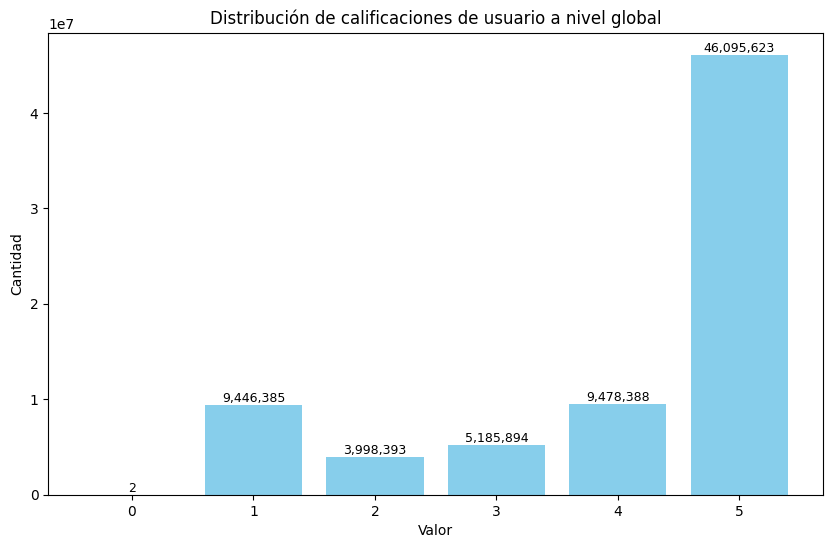

In [20]:
plot_histogram(
    unified_reviews_clean, 'rating', 20,
    'Distribución de calificaciones de usuario a nivel global',
    True
)

## Representación semántica de referencias de productos
La mayor parte del conjunto de datos original se conforma de las reseñas de usuarios de los productos publicados en Amazon. Cada una de estas referencias aporta valor describiendo la satisfacción de los usuarios con respecto al producto usado. En este sentido, vale la pena examinar algunas caracterizaciones preliminares a través de modelos pre-entrenados que permitan representar dichos textos en un formato interpretable por modleos posteriores.

In [21]:
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=es-419
MODULE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load( MODULE_URL )

2025-06-07 15:37:15.011584: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Se usará el modelo Universal Sentence Encoder para generar la representación numérica de las descripciones proveídas por usuarios

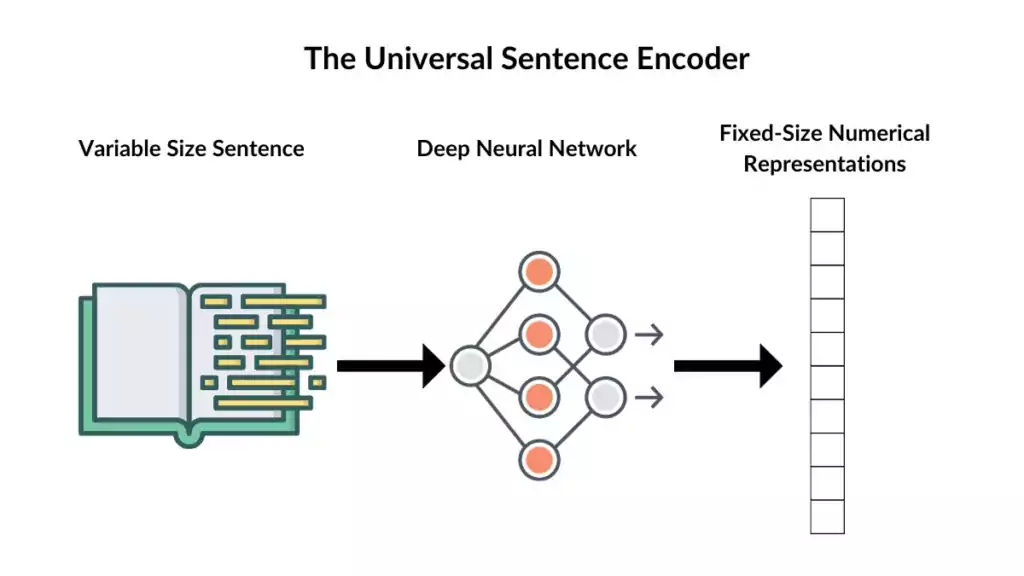

In [22]:
unified_reviews_with_phrases = (
    unified_reviews_clean
        .withColumn(
            'sentence',
            F.explode( F.split(F.col("text"), "\\.") )
        )
)

In [23]:
pandas_sample = (
    unified_reviews_with_phrases
        .filter(
            F.col('sentence').isNotNull() &
            (F.length( F.col('sentence') ) > 0 )
        )
        .limit(100000)
        .toPandas()
)

In [24]:
sentences = pandas_sample['sentence'].to_numpy()

In [25]:
embeddings = model( sentences )
embeddings.shape

2025-06-07 15:37:26.179890: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 816000000 exceeds 10% of free system memory.
2025-06-07 15:37:32.731601: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 816000000 exceeds 10% of free system memory.
2025-06-07 15:37:34.280046: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3484482560 exceeds 10% of free system memory.


TensorShape([100000, 512])

In [26]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.numpy())
f'Varianza explicada: {pca.explained_variance_ratio_.sum() * 100} %'

'Varianza explicada: 9.489971160888672 %'

In [27]:
def sample_and_plot( ax, embedded_2d, words ):
  random_indexes = np.random.choice(embedded_2d.shape[0], size=20, replace=False)
  sampled_labels = [words[i] for i in random_indexes]
  sampled_embedded_2d = embedded_2d[random_indexes]

  ax.scatter(sampled_embedded_2d[:, 0], sampled_embedded_2d[:, 1], color='skyblue')

  for i, _ in enumerate(sampled_labels):
      index = random_indexes[ i ]
      ax.annotate(f'{index}', (sampled_embedded_2d[i, 0], sampled_embedded_2d[i, 1]))

  ax.set_title('Representación de algunas opiniones codificadas mediante modelo pre-entrenado')
  ax.set_xlabel('Comp 1')
  ax.set_ylabel('Comp 2')

  return random_indexes

/tmp/ipykernel_177092/1562355271.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


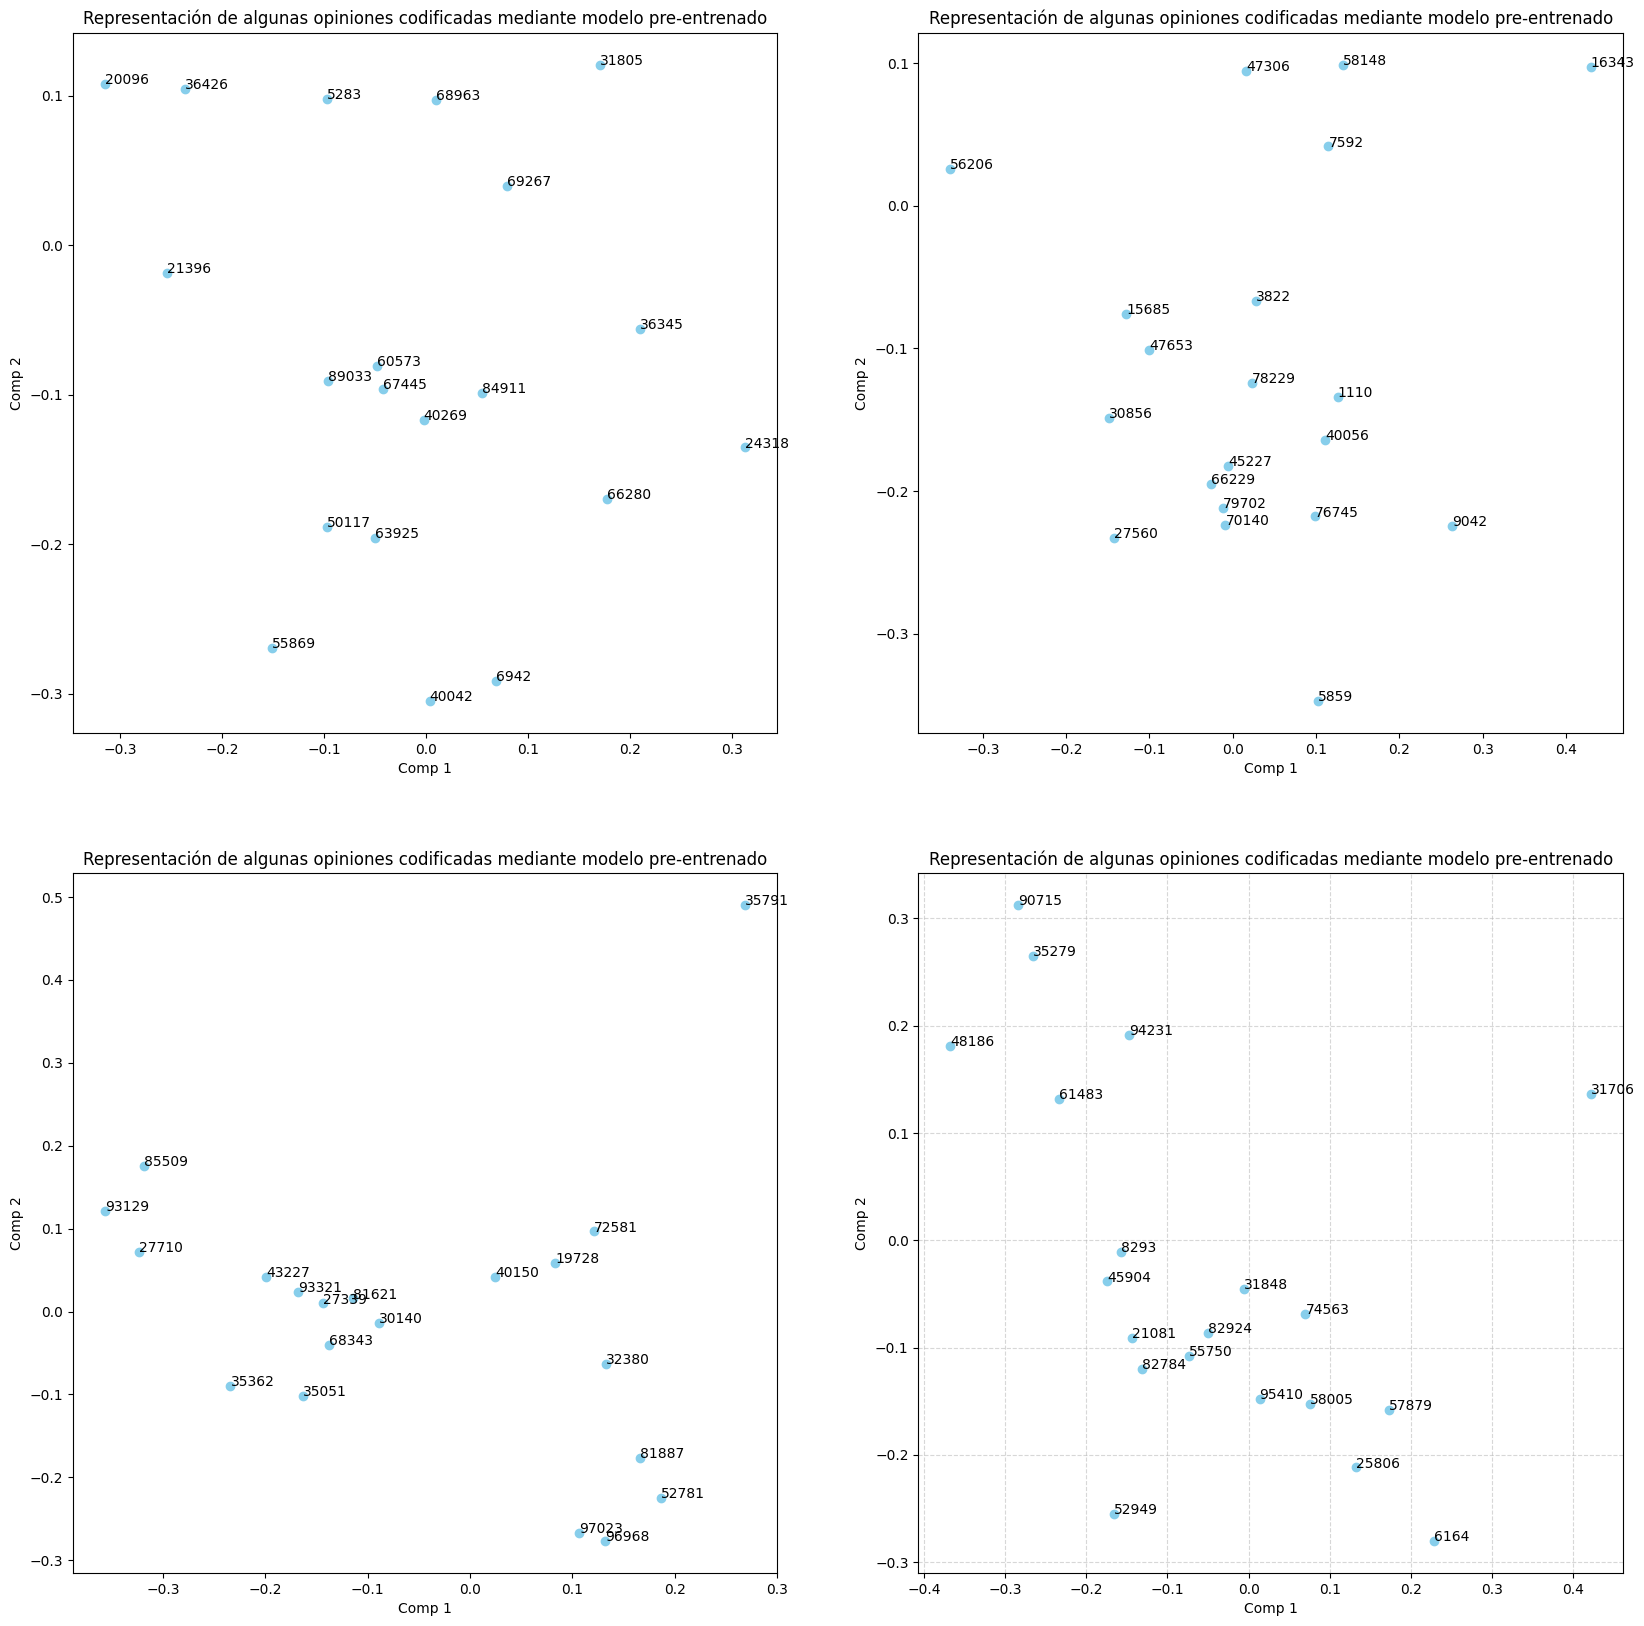

In [28]:
fig, axes = plt.subplots(2,2,figsize=(20, 20))
axes = axes.flatten()

indexes = []

for ax in axes:
    indexes.extend( sample_and_plot( ax, embeddings_2d, sentences ) )

plt.grid(True, linestyle='--', alpha=0.5)
fig.show()

In [29]:
indexes = list(set(indexes))

In [30]:
for id in sorted(indexes):
    print(f'ID: {id} Descripcion: {sentences[id]}')

ID: 1110 Descripcion: Dañado y roto 😠
ID: 3822 Descripcion:  If you want an even faster rate, get one of the shorter IXCC Element Series cables
ID: 5283 Descripcion: Kick-stand was very flimsy and weak
ID: 5859 Descripcion:  Returned and given a refund
ID: 6164 Descripcion:  Won't be a waste of time
ID: 6942 Descripcion: After 6 mos the product failed
ID: 7592 Descripcion:  I received numerous compliments! It is the best price for the great quality it endures
ID: 8293 Descripcion: I am currently using the magnet metal strap and it does it job so far
ID: 9042 Descripcion: Poorly described
ID: 15685 Descripcion:  The mirror is wide enough to view the back seat
ID: 16343 Descripcion: So far so good
ID: 19728 Descripcion: Not very protective
ID: 20096 Descripcion: <br />- The sides are quite grippy, but not in that clingy Apple silicone way where it pulls your pockets inside out and wears out after a few months
ID: 21081 Descripcion:  I now have a broken case with ripped plastic and have w

## Inclusión de imágenes y ejemplos para algunos registros

Se realiza una revisión sobre la estructuración de imágenes y sus correspondientes descripciones asociadas al producto

In [ ]:
import json
from PIL import Image
import io
import numpy as np

def fetch_image_bytes(data):
    result = []

    img_data = json.loads(data.image)

    variant = img_data.get('variant')

    for k, v in img_data.items():

        if k == 'variant': continue

        img = None
        try:
            response = requests.get(v, timeout=5)
            if response.status_code == 200:
                bimg = response.content

        except Exception as e:
            bimg = None

        result.append(
            (k, variant, v, bimg)
        )

    return result


fetch_image_bytes_udf = F.udf(fetch_image_bytes, T.ArrayType(
    T.StructType([
        T.StructField('type', T.StringType()),
        T.StructField('variant', T.StringType()),
        T.StructField('url', T.StringType()),
        T.StructField('data', T.BinaryType()),
    ])
))

In [ ]:
items_images = (
    unified_meta_items
        .select(
            F.col('parent_asin'),
            F.explode( F.col('images') ).alias('image')
        )
        .withColumn(
            'bytes_images', fetch_image_bytes_udf(F.struct(
                F.col('parent_asin'),
                F.col('image')
            ))
        )
        .select(
            F.col('parent_asin'),
            F.explode( F.col('bytes_images') ).alias('bytes_image')
        )
        .select(
            F.col('parent_asin'),
            F.col('bytes_image.type').alias('type'),
            F.col('bytes_image.variant').alias('variant'),
            F.col('bytes_image.url').alias('url'),
            F.col('bytes_image.data').alias('data'),
        )
)

In [ ]:
if REGENERATE_INTERMEDIATE:
    (
        items_images.limit(10).write
            .format('delta')
            .mode('overwrite')
            .saveAsTable('spark_catalog.product_reviews_schema.items_images')
    )

ERROR:root:KeyboardInterrupt while sending command.==>              (6 + 2) / 8]
Traceback (most recent call last):
  File "/mnt/c/Users/User/Documents/Maestría/Amazon Reviews Code/.venv/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/mnt/c/Users/User/Documents/Maestría/Amazon Reviews Code/.venv/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/mnt/c/Users/User/Documents/Maestría/Amazon Reviews Code/.devbox/nix/profile/default/lib/python3.10/socket.py", line 717, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
25/05/24 21:35:29 ERROR PythonUDFRunner: Python worker exited unexpectedly (crashed)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_280563/2030780445.py", line 23, in fetch_image_bytes
  File "/mnt/c/Users/User/Documents/Maestría/A

KeyboardInterrupt: 

In [ ]:
df_items_images = spark.table('spark_catalog.product_reviews_schema.items_images')

In [ ]:
sample_data = df_items_images.limit(10).toPandas()

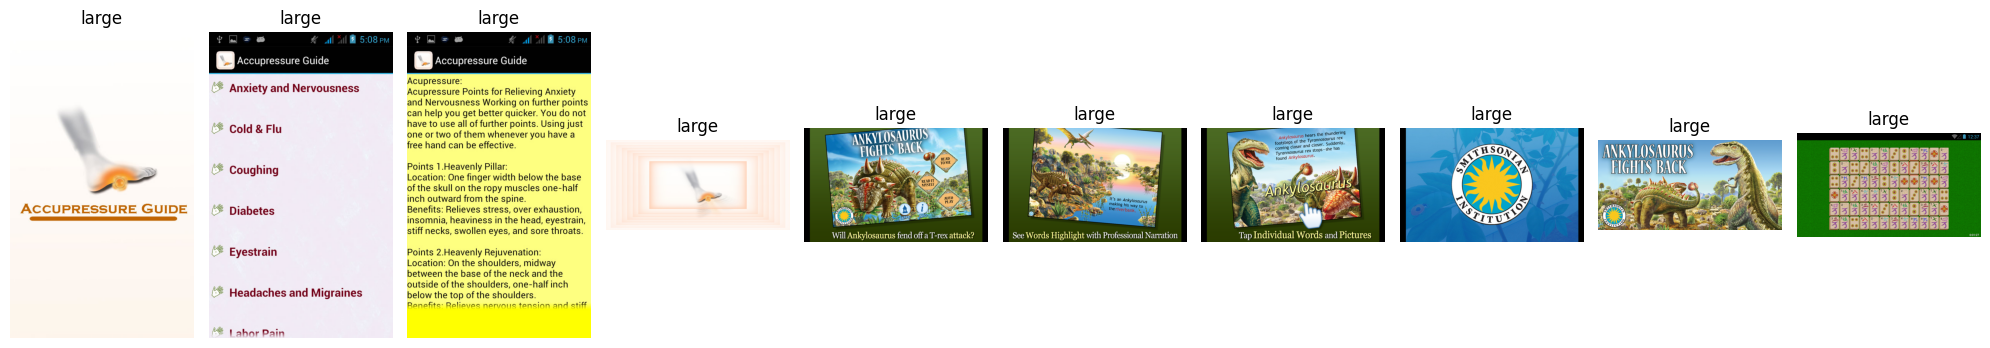

In [ ]:
fig, axes = plt.subplots( 1, 10, figsize = (20,20) )
f_axes = axes.flatten()

for i, (label, img_bytes) in enumerate(zip(sample_data['type'], sample_data['data'])):
    if isinstance(img_bytes, str):
        img_bytes = eval(img_bytes)

    img = Image.open(io.BytesIO(img_bytes))
    f_axes[i].imshow(img)
    f_axes[i].set_title(str(label))
    f_axes[i].axis('off')

for j in range(i + 1, 9):
    f_axes[j].axis('off')

plt.tight_layout()
plt.show()